In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# 将工作环境调整至/data/planogram下
path1 = os.path.abspath('..')
path2 = path1.replace('\\', '/')
os.chdir(path2 + '/data/planogram/')

In [3]:
img = cv2.imread("IMG_0114.jpg", 1)

In [4]:
def color_image_show(img):
    plt.figure(figsize=(10, 12))
    image_show = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(image_show, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

In [5]:
def gray_image_show(img):
    plt.figure(figsize=(10, 12))
    plt.imshow(img, cmap='gray', interpolation='bicubic')
    plt.xticks([]), plt.yticks([])
    plt.show()

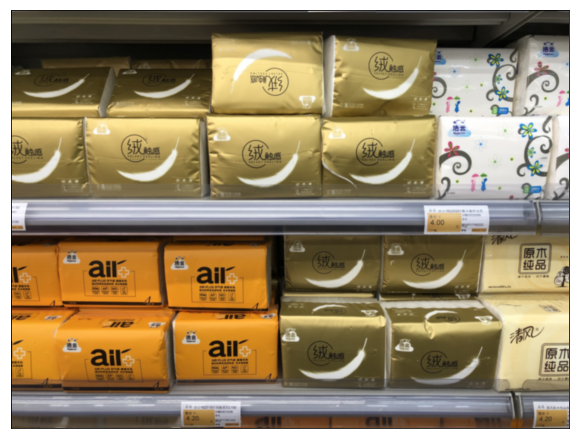

In [6]:
color_image_show(img)

In [7]:
img.shape

(3024, 4032, 3)

## 图像灰度化

In [8]:
# 灰度化各通道权重大小 Y = 0.299R + 0.587G + 0.114B
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

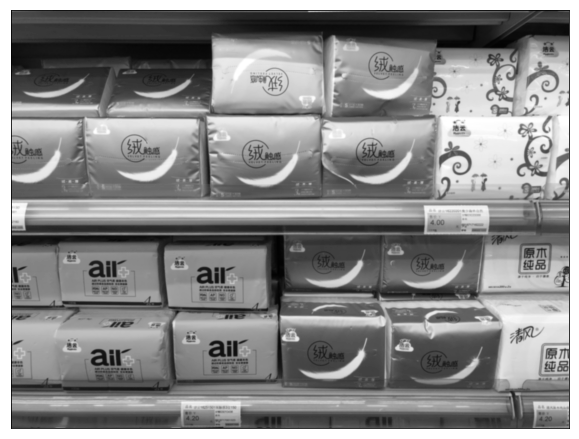

In [9]:
gray_image_show(gray_img)

## 对图像进行高斯平滑

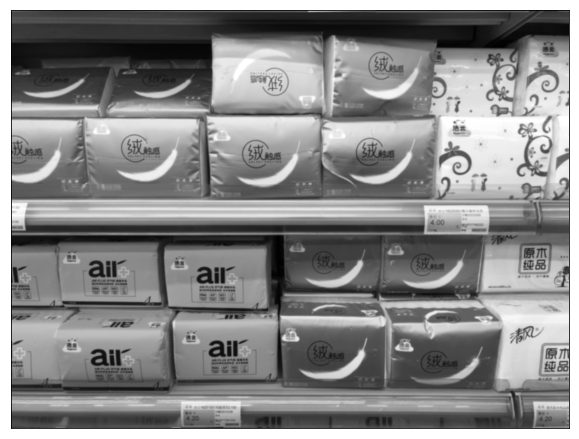

In [10]:
# 如果高斯滤波器大小设置为9*9, 则平滑过度, 部分细节无法检测
blur_img = cv2.GaussianBlur(gray_img, (5, 5), 2)
gray_image_show(blur_img)

## 使用canny算法检测图像边缘

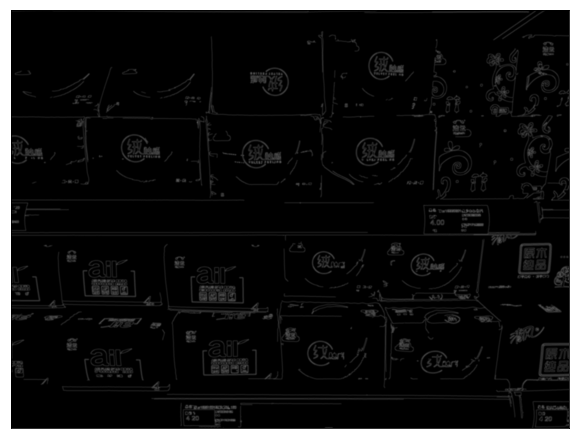

In [11]:
canny_img = cv2.Canny(blur_img, 50, 200)
gray_image_show(canny_img)

## 未平滑的图像应用canny算子

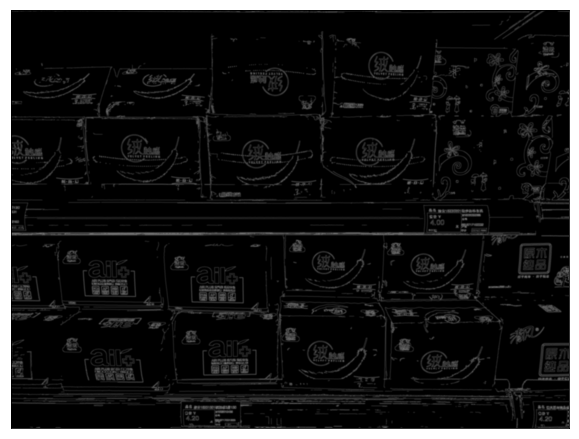

In [12]:
canny_img2 = cv2.Canny(gray_img, 100, 200)
gray_image_show(canny_img2)

## 霍夫变换检测直线

In [13]:
img_hough = canny_img.copy()
lines = cv2.HoughLines(img_hough, 1, np.pi/180, 350)

In [14]:
lines.shape

(34, 1, 2)

In [15]:
def line_painter(image, lines):
    for line in lines:
        length = max(image.shape[0], image.shape[1])
        rho = line[0][0]
        theta = line[0][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + length * (-b))
        y1 = int(y0 + length * a)
        x2 = int(x0 - length * (-b))
        y2 = int(y0 - length * a)
        cv2.line(image, (x1, y1), (x2, y2), (255, 0, 0), 1)

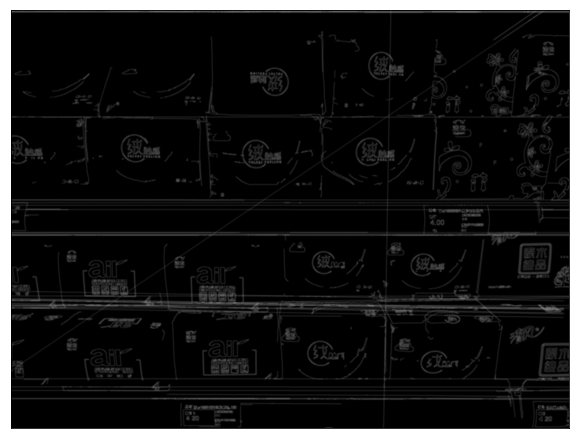

In [16]:
line_painter(img_hough, lines)
gray_image_show(img_hough)

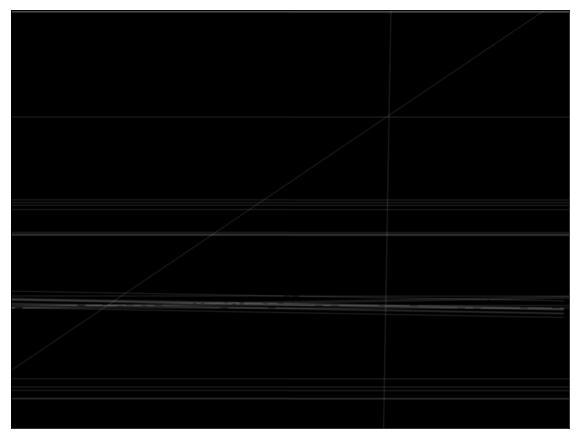

In [17]:
img_background = np.zeros(img_hough.shape)
line_painter(img_background, lines)
gray_image_show(img_background)

In [18]:
lines[0][0]

array([2.8100000e+03, 1.5707964e+00], dtype=float32)

In [19]:
lines_array = []
for line in lines:
    lines_array.append(line[0])

lines_data = pd.DataFrame(np.array(lines_array), columns=['rho', 'theta'])

In [20]:
# 弧度转角度
np.rad2deg(lines[0][0][1])

90.0

In [21]:
lines_data['angle'] = lines_data['theta'].map(lambda x: round(np.rad2deg(x)))

In [22]:
lines_data['angle'].value_counts()

90.0    22
91.0     8
89.0     2
1.0      1
56.0     1
Name: angle, dtype: int64

## 图像二值化——局部阈值化

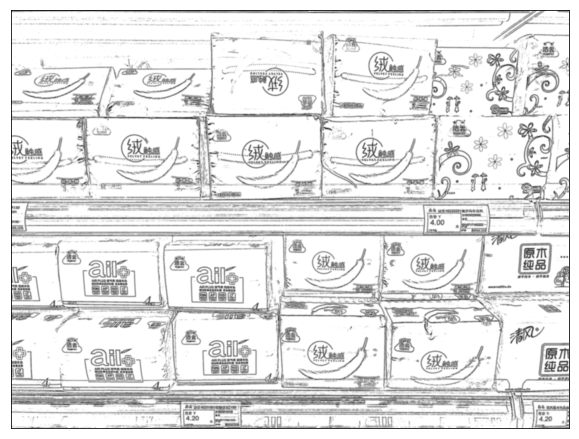

In [23]:
binary_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 2)
gray_image_show(binary_img)

## 计算二值化图像每行灰度的累加值

In [24]:
gray_array = []
for line in binary_img:
    gray_array.append(line.sum())

gray_array = np.asanyarray(gray_array)
gray_statistics = pd.DataFrame(gray_array, columns=['gray_sum'])
# 对灰度值做归一化处理
gray_statistics = gray_statistics/gray_array.max()

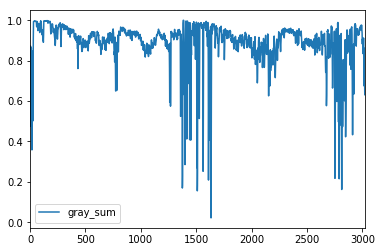

In [25]:
gray_statistics.plot()

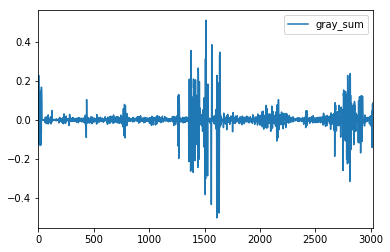

In [26]:
# 一阶差分图像
gray_statistics.diff().plot()

## 对canny边缘图像做上述相同的处理

In [27]:
gray_array_2 = []
for line in canny_img:
    gray_array_2.append(line.sum())

gray_array_2 = np.asarray(gray_array_2)
gray_statistics_2 = pd.DataFrame(gray_array_2, columns=['gray_sum'])
gray_statistics_2 = gray_statistics_2/gray_array_2.max()

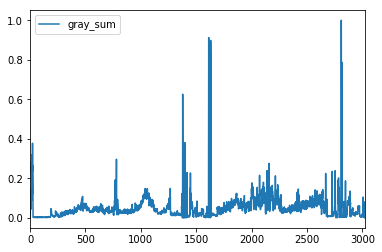

In [28]:
gray_statistics_2.plot()

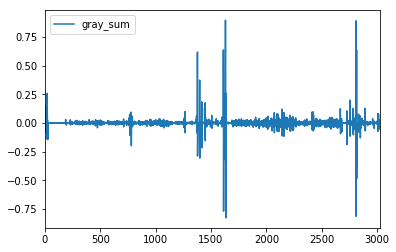

In [29]:
gray_statistics_2.diff().plot()

****可以看出canny边缘图像相较于二值化图像的查分统计结果更好**

In [30]:
gray_diff_statistics_2 = gray_statistics_2.diff()
gray_diff_statistics_2[gray_diff_statistics_2['gray_sum'] > 0.5]

,gray_sum
1378,0.617307
1612,0.636197
1631,0.894576
2810,0.889701
2815,0.634369


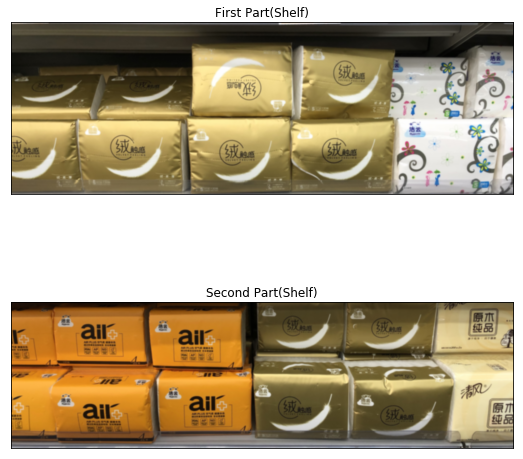

In [31]:
plt.figure(figsize=(9, 9))

plt.subplot(2, 1, 1)
img_part_1 = img[0:1378]
image_show_1 = cv2.cvtColor(img_part_1, cv2.COLOR_BGR2RGB)
plt.imshow(image_show_1, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])
plt.title('First Part(Shelf)')

plt.subplot(2, 1, 2)
img_part_2 = img[1631:2809]
image_show_2 = cv2.cvtColor(img_part_2, cv2.COLOR_BGR2RGB)
plt.imshow(image_show_2, cmap='gray', interpolation='bicubic')
plt.xticks([]), plt.yticks([])
plt.title('Second Part(Shelf)')

plt.show()


In [32]:
os.chdir(path2 + '/data/planogram_segmented/')
cv2.imwrite('IMG_0114_1.jpg', img_part_1)
cv2.imwrite('IMG_0114_2.jpg', img_part_2)

True